In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']

print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
sys.path.append('../detector/')
from DeepFakeDetector import DeepFakeDetector
sys.path.append('../util/')

/home/joni/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Copy the facenet pretrained weights to cache
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [5]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,-9.223372e+18,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,-9.223372e+18,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,1.000000e+00,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [6]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [7]:
n_first_frames = 10
n_spaced_frames = 10
pretrained_paths = '../pretrained_models/'
models_root_dir = '../kaggle_datasets/deepfake_2020_03_09/'

deepFakeDetector = DeepFakeDetector(deepfake_models_directory=models_root_dir,
                                    third_party_models_directory=pretrained_paths,
                                    n_first_frames=n_first_frames,
                                    n_spaced_frames=n_spaced_frames)

cuda:0
Loaded video frame sampler.
Loaded face detectors.
Loaded pytorch facenet face embeddings model.
Loaded 2 small face classifier and 2 large face classifier models.
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
Loaded 2 face sequence classifier models.
Loaded 0 second level xgb classifier models and 0 logistic regression models.
##################################################
DeepFakeDetector v.0.5.2
Sample 10 first frames and 10 spaced frames.
Number of max retries is 5
On error cases, predict 0.5
##################################################


In [8]:
featNames = deepFakeDetector.GetFeatureNames()
print("Num features: " + str(len(featNames)))
featNames

Num features: 124


array(['small_face_clf_mean_0_original_first', 'small_face_clf_max_0_original_first',
       'small_face_clf_std_0_original_first', 'small_face_clf_median_0_original_first', ...,
       'seq_clf_len-5_start-10_1_zoom_mean', 'seq_clf_len-5_start-10_1_zoom_max', 'seq_clf_len-5_start-10_1_zoom_std',
       'seq_clf_len-5_start-10_1_zoom_median'], dtype='<U48')

In [10]:
%%time
feats = deepFakeDetector.GetFeatures(filenames[2], p_random_compression=True) # 9008, 43337, 8298
feats

CPU times: user 9.33 s, sys: 80.8 ms, total: 9.42 s
Wall time: 4.1 s


[array([0.998365, 0.999905, 0.002682, 0.999516, ..., 0.968987, 0.968987, 0.      , 0.968987], dtype=float32)]

In [11]:
for (feat, name) in zip(feats[0],featNames):
    print(feat, name)

0.9983646 small_face_clf_mean_0_original_first
0.999905 small_face_clf_max_0_original_first
0.0026819848 small_face_clf_std_0_original_first
0.99951625 small_face_clf_median_0_original_first
0.9715441 small_face_clf_mean_0_original_spaced
0.99987817 small_face_clf_max_0_original_spaced
0.06445267 small_face_clf_std_0_original_spaced
0.99722743 small_face_clf_median_0_original_spaced
0.9761081 small_face_clf_mean_1_original_first
0.9892489 small_face_clf_max_1_original_first
0.011979218 small_face_clf_std_1_original_first
0.9763617 small_face_clf_median_1_original_first
0.97541046 small_face_clf_mean_1_original_spaced
0.98961043 small_face_clf_max_1_original_spaced
0.015981637 small_face_clf_std_1_original_spaced
0.9813688 small_face_clf_median_1_original_spaced
0.9964832 small_face_clf_mean_0_bright_first
0.9998603 small_face_clf_max_0_bright_first
0.0035654374 small_face_clf_std_0_bright_first
0.9977771 small_face_clf_median_0_bright_first
0.8443922 small_face_clf_mean_0_bright_spaced

In [12]:
df = df[df['isVal']==True]
df = df[df['cv_fold']<999]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
7,hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
25,sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
26,eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.000000e+00,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",pfvywdrbno.mp4,2020-02-17
27,mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
31,kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


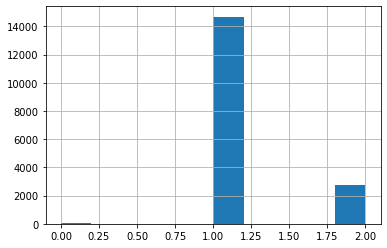

In [13]:
df.person_count.hist()

In [14]:
df.first_person_label.describe()

count    1.748700e+04
mean    -1.371348e+16
std      3.553923e+17
min     -9.223372e+18
25%      0.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: first_person_label, dtype: float64

In [15]:
df = df.set_index('index')
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.000000e+00,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",pfvywdrbno.mp4,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


In [16]:
df_one_person = df[df['person_count']==1]
fake_real_ratio = len(df_one_person[df_one_person['label']=='FAKE']) / len(df_one_person[df_one_person['label']=='REAL'])
print('There are {0:.2} times more fakes'.format(fake_real_ratio))

There are 2.7 times more fakes


In [17]:
MISSING_VAL = 0.5

In [18]:
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.000000e+00,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",pfvywdrbno.mp4,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


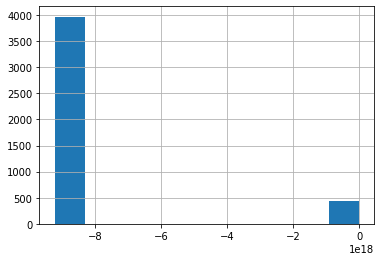

In [19]:
df[df['label']=='REAL'].second_person_label.hist()

In [20]:
from tqdm.notebook import tqdm as tqdm
import random
random.seed(2020)

subsample = 10000

#raw lists
preds_fake = []
preds_real = []

split_fake = []
split_real = []

keys=df.index.values
feat_len = featNames.shape[0]

for i, filename in enumerate(tqdm(filenames)):#[:subsample])):
    if i%500==0: # all garbage is not handled right
        gc.collect()
        
    plain_name = str(filename).split('/')[len(str(filename).split('/'))-1]
    if plain_name not in keys:
        continue
    is_fake = True if df.at[plain_name,'label'] == 'FAKE' else False
    
    #sample fakes the same amount as reals and sample randomly
    if is_fake and random.randint(0,int(round(10*fake_real_ratio))) >= 10:
        continue
    
    split = df.at[plain_name,'cv_fold']
    try:
        preds = deepFakeDetector.GetFeatures(str(filename), p_random_compression=(i%2==0))
    except:
        print("Error with " + str(filename) + ' - ' + str(i))
        if is_fake:
            preds_fake.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_fake.append(split)
        else:
            preds_real.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_real.append(split)
        continue
        
    def _addPred(preds, split, is_fake):
        if is_fake:
            preds_fake.append(preds)
            split_fake.append(split)
        else:
            preds_real.append(preds)
            split_real.append(split)
    
    # preds can have two persons
    if len(preds) > 1:
        continue # skip for now
        # include both
        first_label = df.loc[plain_name]['first_person_label']
        second_label = df.loc[plain_name]['second_person_label']
        if first_label == 0:
            _addPred(preds[0], split, False)
        elif first_label > 0:
            _addPred(preds[0], split, True)
            
        # this assumes the face order is the same
        if second_label == 0:
            _addPred(preds[1], split, False)
        elif second_label > 0:
            _addPred(preds[1], split, True)
    else:
        _addPred(preds[0], split, is_fake)

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_16/coilvztxsl.mp4 - 214
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_16/valczjlvii.mp4 - 1668
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/cwqiiminqn.mp4 - 12843
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/dsjelqqcbe.mp4 - 12940
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/mzyhpqybqh.mp4 - 14167
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/qjracbrmzo.mp4 - 14665
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/trlhchyeij.mp4 - 15112
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/tyhxxjltbs.mp4 - 15140
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/xrdtisplaq.mp4 - 15664
Error with /m

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/aoigsecafe.mp4 - 84376
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/aqhlpyacll.mp4 - 84382
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/avcftqodfe.mp4 - 84397
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/bknczlsdia.mp4 - 84405
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/dwpjyidlfg.mp4 - 84685
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/eelegoxjwv.mp4 - 84712
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/eudnjqzhac.mp4 - 84760
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/ffikhwxjgm.mp4 - 84797
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/fibctjkhly.mp4 - 84807
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_36/fkebsdemzh.mp4 - 84813
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/sftvafvaxj.mp4 - 110456
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/tvowbquorj.mp4 - 110610
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/tzvvzcdldj.mp4 - 110626
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/umoutofncx.mp4 - 110663
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/upuobpieop.mp4 - 110678
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/uskjtnuvbd.mp4 - 110685
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/vxqofldgze.mp4 - 110774
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/wjpeznrhww.mp4 - 110829
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/xhwjtmumsr.mp4 - 110908
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/ypcfjnfqfw.mp4 - 111007
Error with /mnt/945C2D6E5C2D4B

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/hdvrxlrnyk.mp4 - 114242
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/hmhnfzfrro.mp4 - 114261
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/hrrwofyxnz.mp4 - 114282
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/inlurljyft.mp4 - 114359
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/jfcsumiude.mp4 - 114419
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/jnklpeolur.mp4 - 114450
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/khnqntehnr.mp4 - 114549
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/knpxmrizay.mp4 - 114569
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/lrrptmaseg.mp4 - 114666
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/nhldlpnhvr.mp4 - 114809
Error with /mnt/945C2D6E5C2D4B

/home/joni/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joni/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bmgidxpirq.mp4 - 116191
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bxzzmbhwiu.mp4 - 116248
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/cllsklblbu.mp4 - 116303
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/cppztnbtvs.mp4 - 116317
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/crpmgqavlf.mp4 - 116329
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/ctzvhowbhr.mp4 - 116344
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/cujqbmziws.mp4 - 116347
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/dermobcmbu.mp4 - 116393
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/dtskukyggw.mp4 - 116456
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/efsxoprojd.mp4 - 116504
Error with /mnt/945C2D6E5C2D4B

/home/joni/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joni/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/enyhgljqwr.mp4 - 116547
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/eomkkrghqx.mp4 - 116548
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/eufxjsolyv.mp4 - 116573


/home/joni/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joni/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/hvefzshjxl.mp4 - 116913
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/kemappvqpu.mp4 - 117229
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/kinqjsgfum.mp4 - 117273
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/kqtxuuqpxx.mp4 - 117303
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/lzdtgzczma.mp4 - 117459
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/mcdgaxfego.mp4 - 117468
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/mgxkzuxhdh.mp4 - 117488
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/mozbuksqvr.mp4 - 117520
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/nbsjrgghfg.mp4 - 117581
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/ngvscvetrq.mp4 - 117613
Error with /mnt/945C2D6E5C2D4B

/home/joni/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joni/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/ntzbmwcatz.mp4 - 117682
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/nwbuqdfaym.mp4 - 117693
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/oemhtukett.mp4 - 117721


/home/joni/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joni/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/oqmgquqrzg.mp4 - 117767
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/oyjgsuyybk.mp4 - 117797
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/pzsxcaflwj.mp4 - 117925
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/qwtcmikhmd.mp4 - 118036
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/rdpausigpg.mp4 - 118072


/home/joni/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joni/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/rhotsujndc.mp4 - 118091
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/rmcwnpvsdq.mp4 - 118116
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/rsjhmrvdwg.mp4 - 118142
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/snphwtfljw.mp4 - 118256
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/upjsffsjto.mp4 - 118505
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/uuhnhpsnct.mp4 - 118524
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/uzoodbatvz.mp4 - 118545
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/vplyyujkof.mp4 - 118608
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/vuuwqdriya.mp4 - 118646
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/vvmntqbqxb.mp4 - 118651
Error with /mnt/945C2D6E5C2D4B

/home/joni/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joni/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/wodyvmsrro.mp4 - 118727
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/wyqhadmmcy.mp4 - 118788
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/xgpqvqoxgd.mp4 - 118829
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/xiraodtgnt.mp4 - 118837
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/ynhpdkhtqp.mp4 - 118958
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zitaceokgz.mp4 - 119055
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zogpehscmc.mp4 - 119100



In [21]:
# is the set balanced?
print(len(preds_real), len(preds_fake))

4049 3979


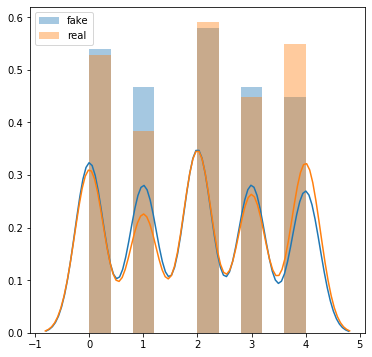

In [22]:
# are the splits balanced?
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(split_fake,bins=10, ax=ax, label='fake')
sns.distplot(split_real,bins=10, ax=ax, label='real')
ax.legend()

# Plot distributions for each feature

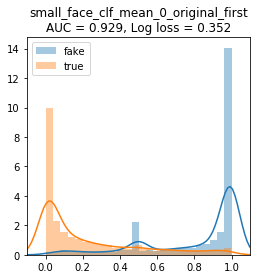

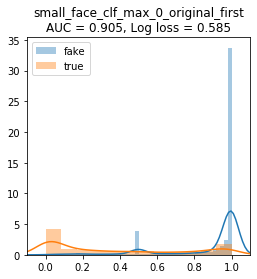

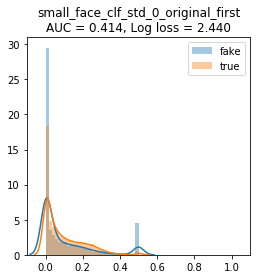

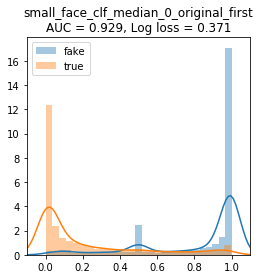

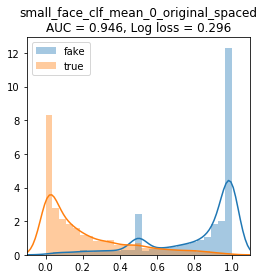

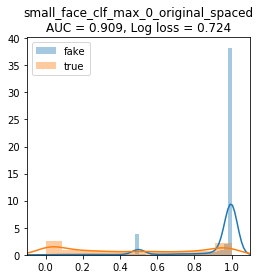

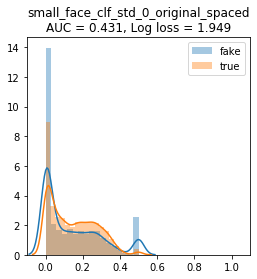

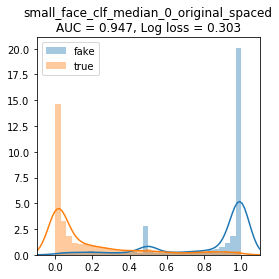

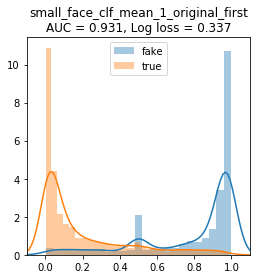

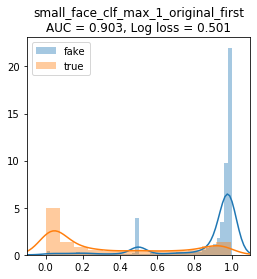

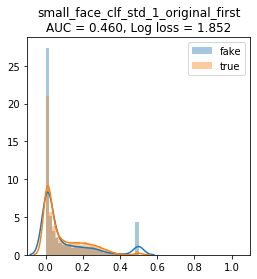

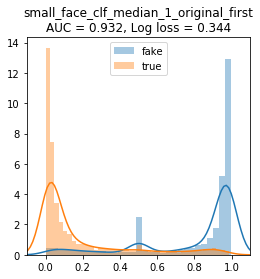

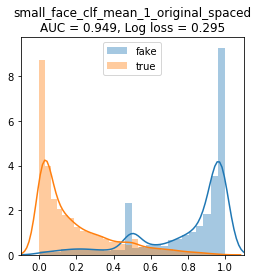

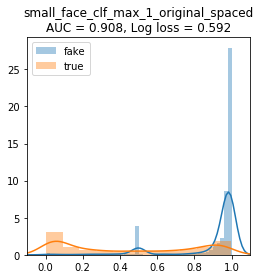

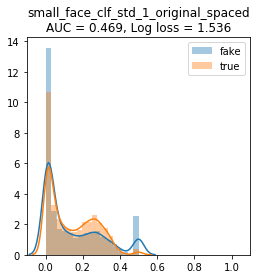

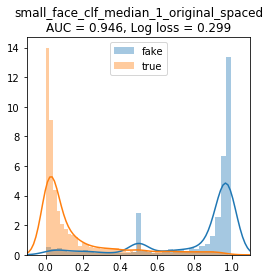

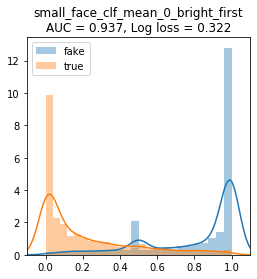

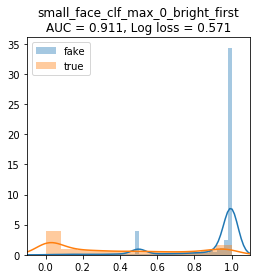

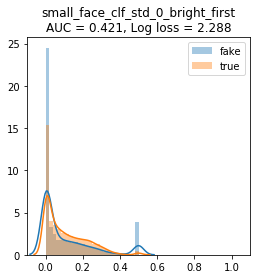

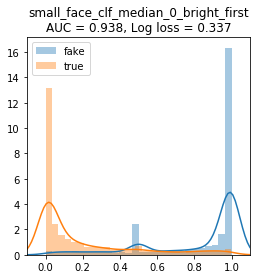

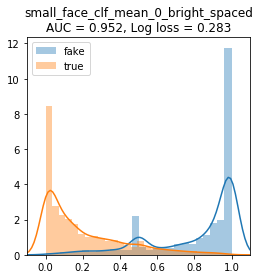

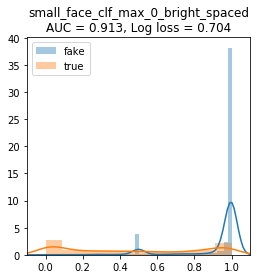

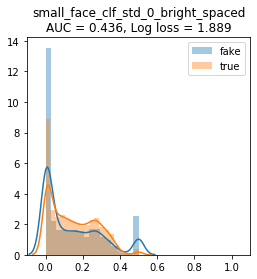

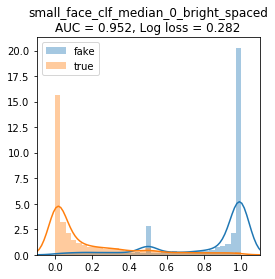

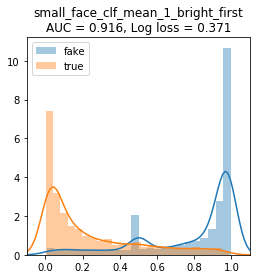

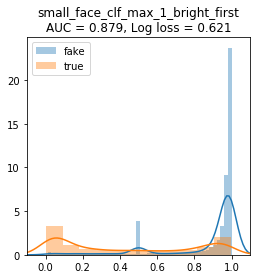

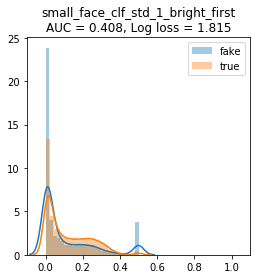

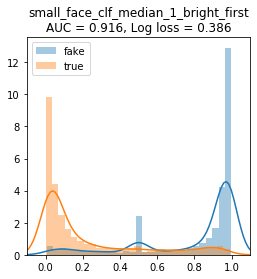

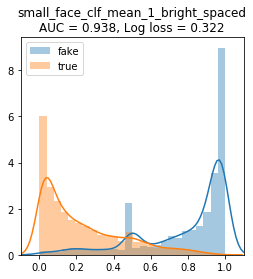

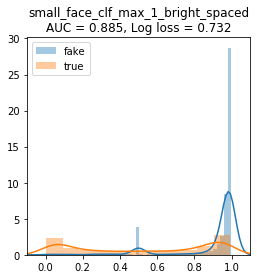

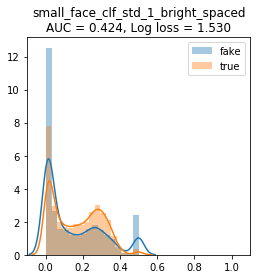

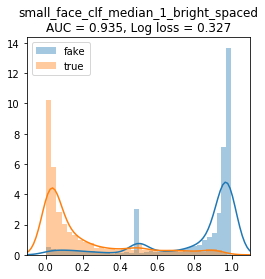

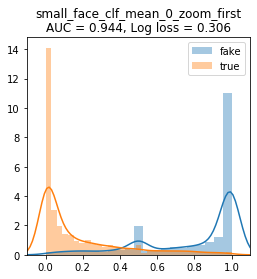

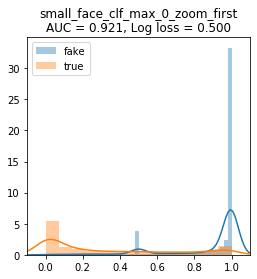

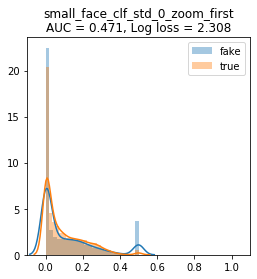

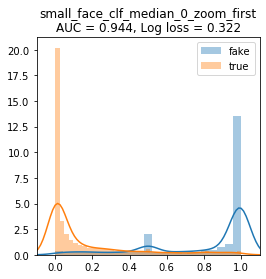

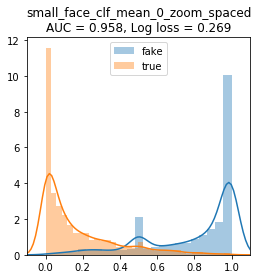

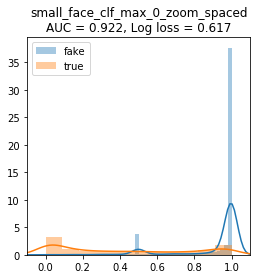

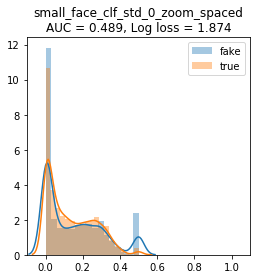

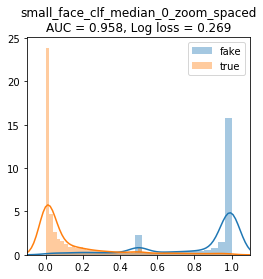

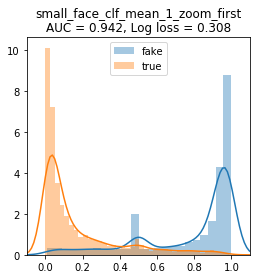

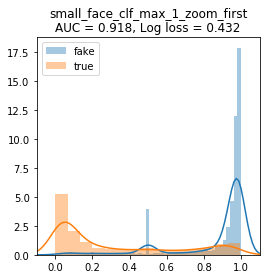

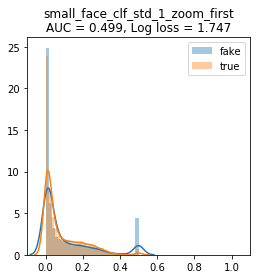

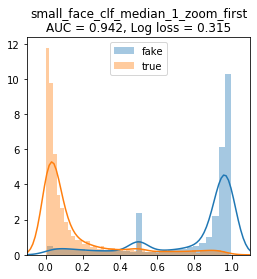

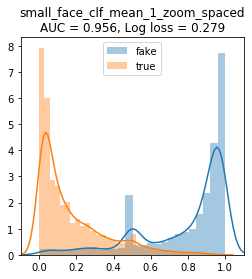

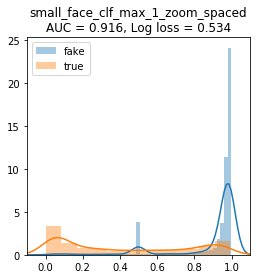

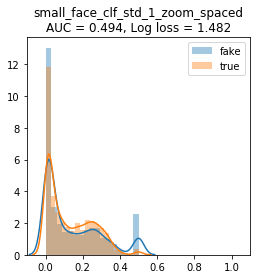

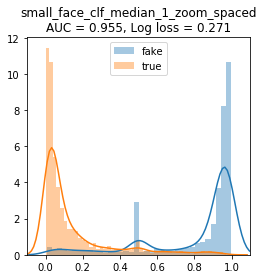

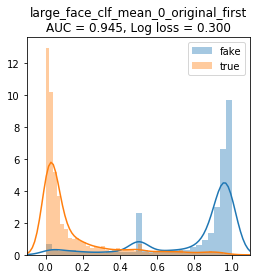

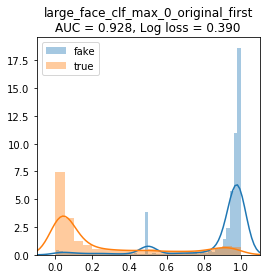

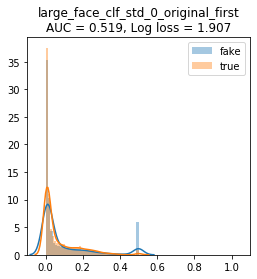

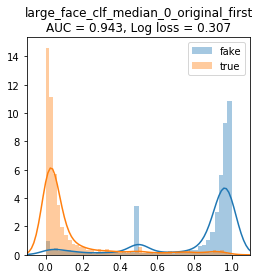

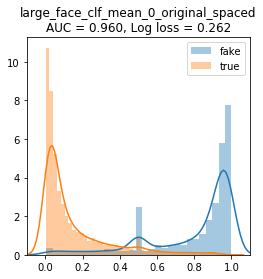

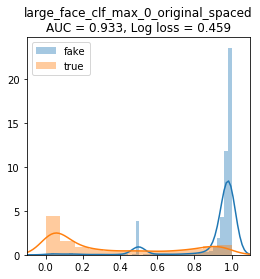

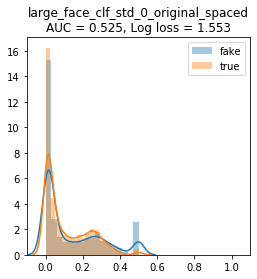

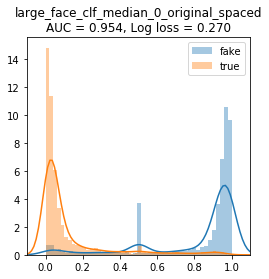

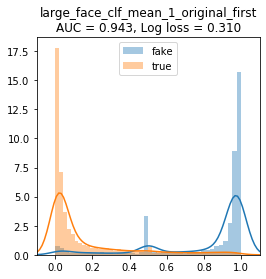

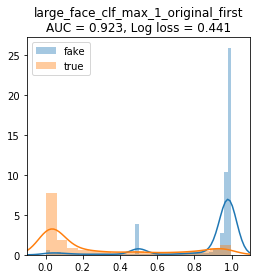

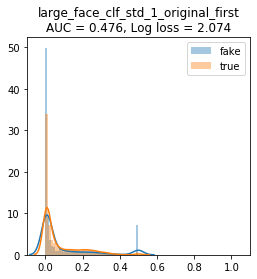

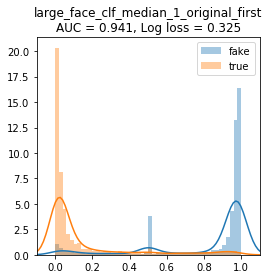

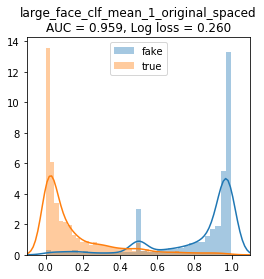

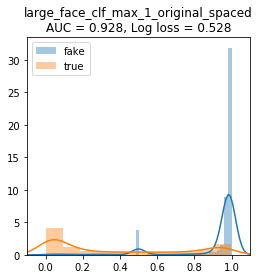

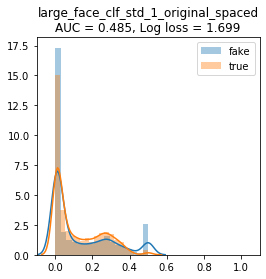

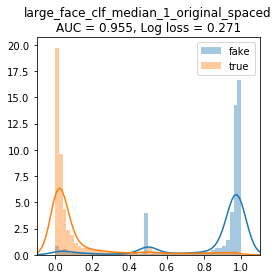

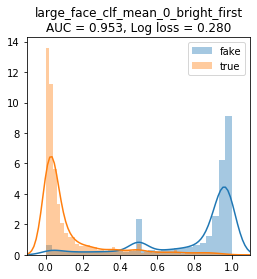

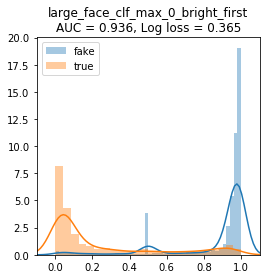

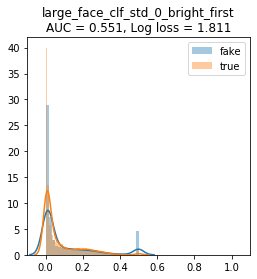

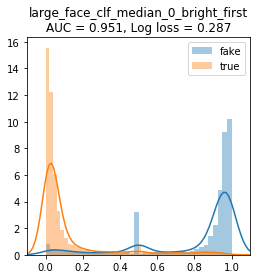

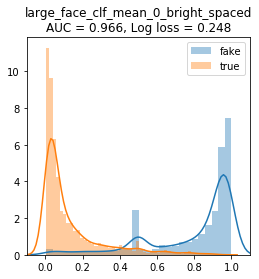

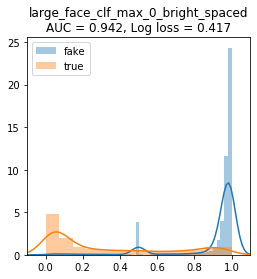

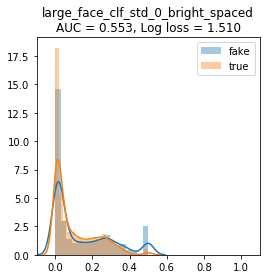

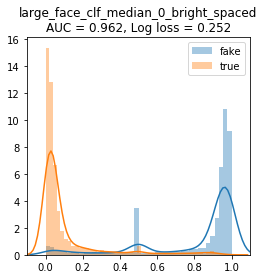

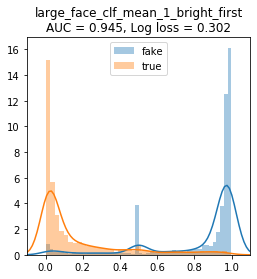

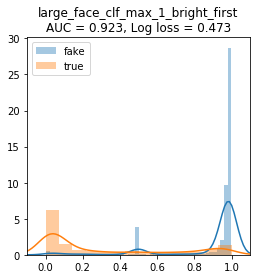

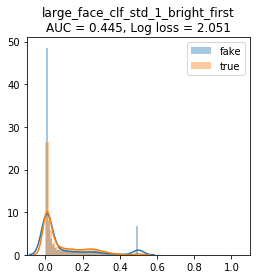

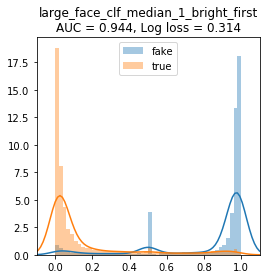

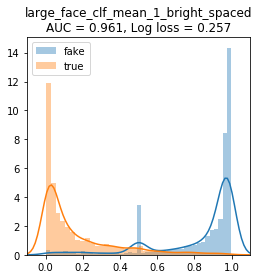

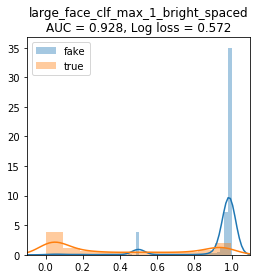

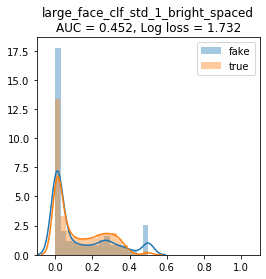

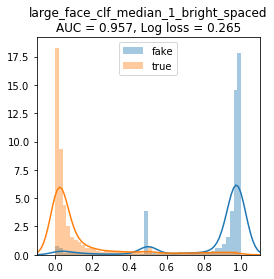

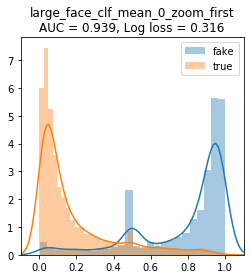

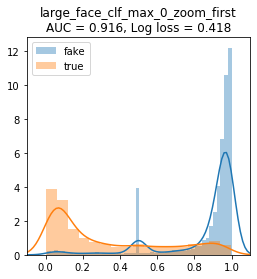

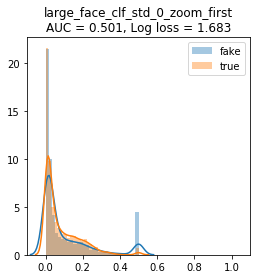

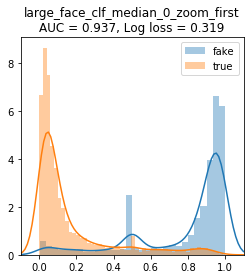

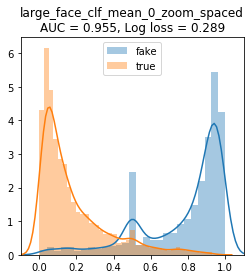

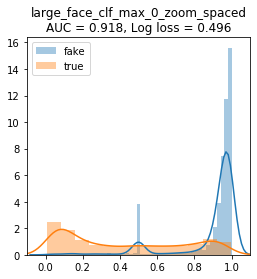

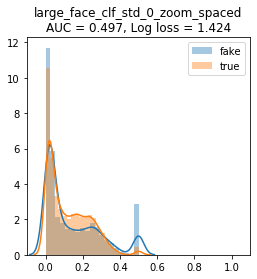

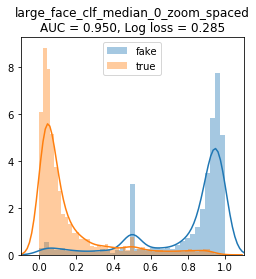

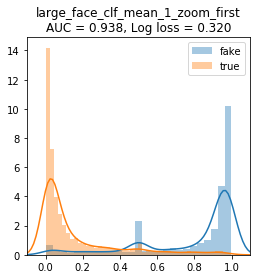

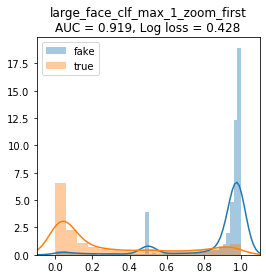

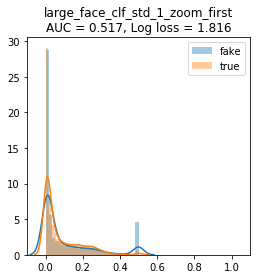

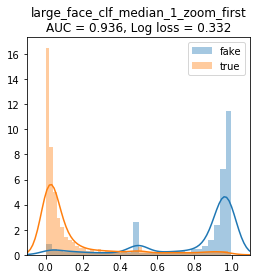

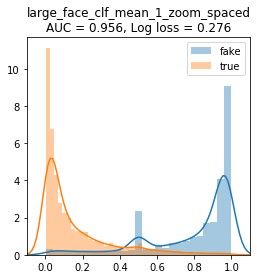

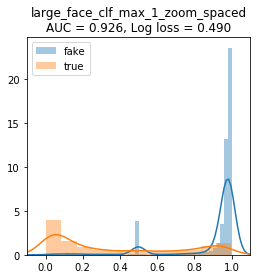

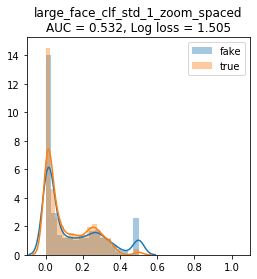

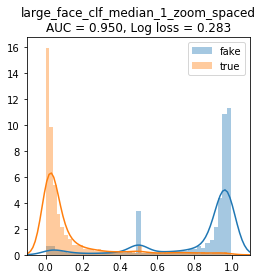

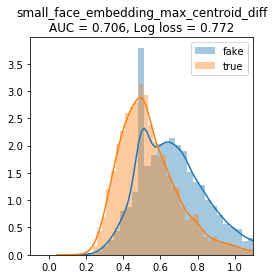

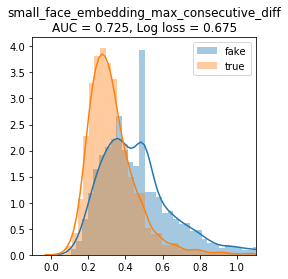

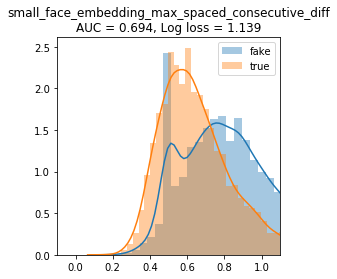

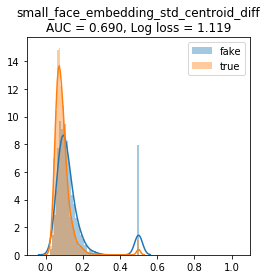

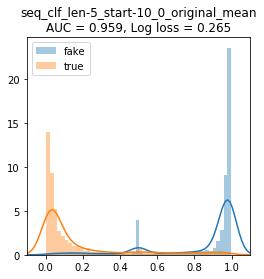

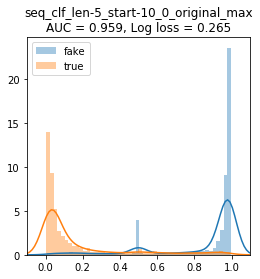

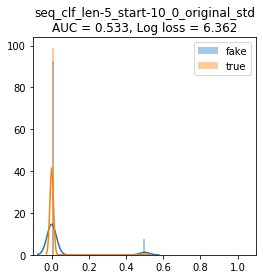

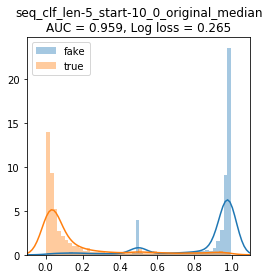

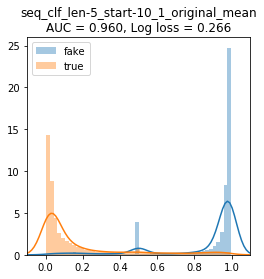

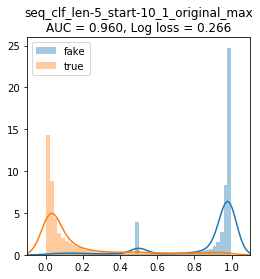

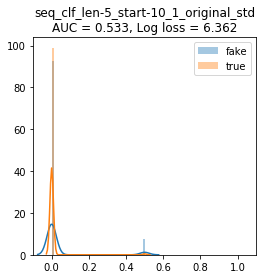

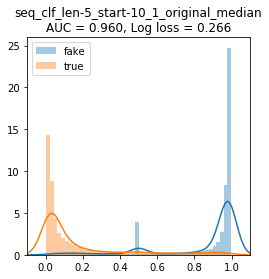

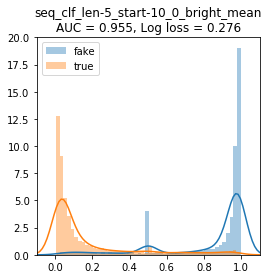

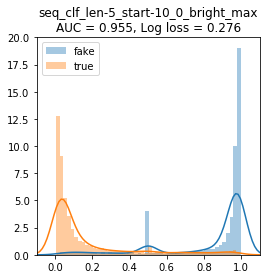

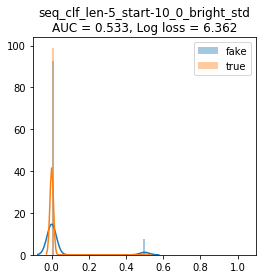

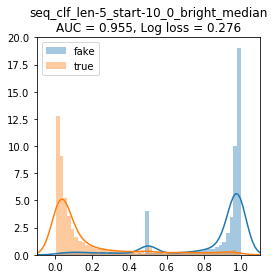

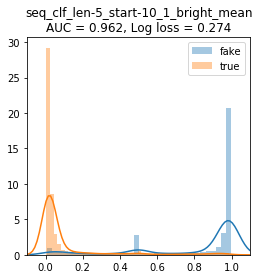

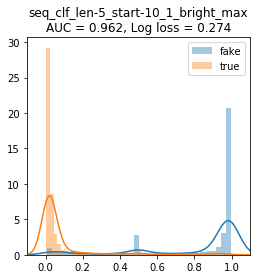

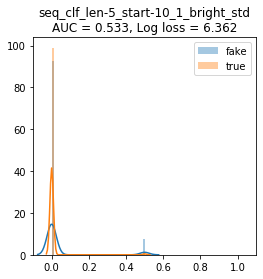

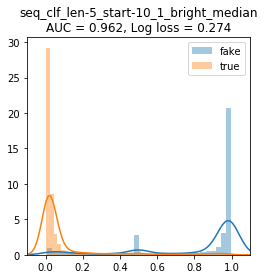

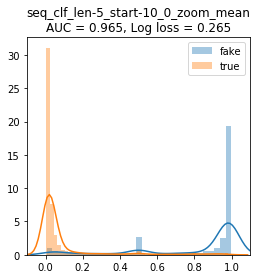

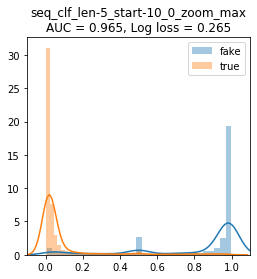

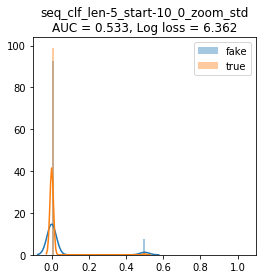

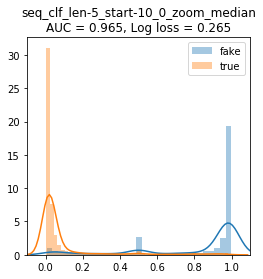

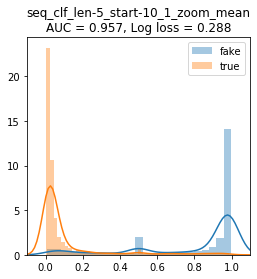

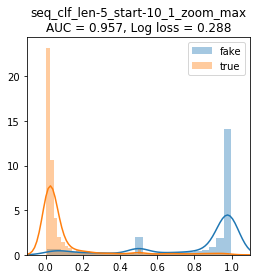

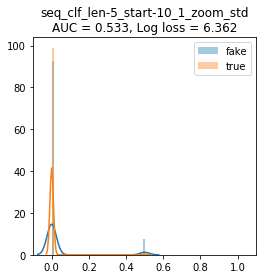

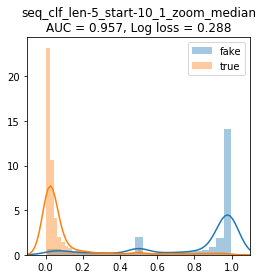

In [23]:
import matplotlib.axes
from sklearn.metrics import roc_auc_score, log_loss

def getAuc(fake_list, real_list):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    return roc_auc_score(true_labels,pred_labels)

def getLogLoss(fake_list, real_list, eps=1e-6):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    # epsilon clip to avoid nans
    pred_labels = np.clip(pred_labels,eps,1-eps)
    return log_loss(true_labels,pred_labels)

def plotFakeReal(feature_index):
    fake_list = list(np.array(preds_fake)[:,feature_index])
    real_list = list(np.array(preds_real)[:,feature_index])
    auc = getAuc(fake_list, real_list)
    logloss = getLogLoss(fake_list, real_list)
    f, ax = plt.subplots(1,1,figsize=(4,4))
    sns.distplot(fake_list, ax=ax, label='fake')
    sns.distplot(real_list, ax=ax, label='true')
    ax.set_title(featNames[feature_index] + '\n' + 'AUC = {0:.3f}, Log loss = {1:.3f}'.format(auc,logloss))
    ax.set_xlim(-0.1,1.1)
    #ax.set_ylim(0,5)
    ax.legend()
    plt.show()

for i in range(preds_fake[0].shape[0]):
    plotFakeReal(i)

# Feature classifier from XGBoost

In [24]:
# collect vectors
ys = np.concatenate([np.ones(len(preds_fake)), np.zeros(len(preds_real))])
xs_fake = np.array(preds_fake)
xs_real = np.array(preds_real)
xs = np.concatenate([xs_fake, xs_real], axis=0)
splits = np.concatenate([split_fake, split_real])
print(ys.shape)
print(xs.shape)
print(splits.shape)

(8028,)
(8028, 124)
(8028,)


In [25]:
# save for later
np.save("./saved_val_xs.npy", xs)
np.save("./saved_val_ys.npy", ys)
np.save("./saved_val_splits.npy", splits)

# Checkpoint

In [26]:
xs = np.load("./saved_val_xs.npy")
ys = np.load("./saved_val_ys.npy")
splits = np.load("./saved_val_splits.npy")

In [26]:
np.unique(splits, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1713, 1364, 1879, 1468, 1604]))

In [27]:
def getSplitParts(fold=0, removeMissing=False):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for x,y,f in zip(xs,ys,splits):
        if(removeMissing and x[0]==MISSING_VAL):
            continue
        if f==999: # error cases
            continue
        if f==fold:
            X_test.append(x)
            y_test.append(y)
        else:
            X_train.append(x)
            y_train.append(y)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [28]:
DIR_SECOND_LEVEL = '../models/second_level_models'
if not os.path.exists(DIR_SECOND_LEVEL):
    os.mkdir(DIR_SECOND_LEVEL)
DIR_EXPERIMENT = os.path.join(DIR_SECOND_LEVEL, '2020_03_10')
if not os.path.isdir(DIR_EXPERIMENT):
    os.mkdir(DIR_EXPERIMENT)

In [29]:
from sklearn.metrics import log_loss
import xgboost as xgb

losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
xgb_models = []
eps = 1e-6
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = "logloss"
    
    model = xgb.XGBClassifier(objective='reg:squarederror',#'binary:logistic', 
                             learning_rate = 0.1, 
                             max_depth = 3,
                             gamma=3,
                             subsample = 0.8,
                             colsample_bytree = 1,
                             reg_lambda=1,
                             reg_alpha=0.3,
                             alpha = 10, 
                             n_estimators = 80,
                             missing=MISSING_VAL)
    model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
    model.save_model(str(os.path.join(DIR_EXPERIMENT,'second_level_xgb_{0}.bin'.format(fold))))
    xgb_models.append(model)
    
    y_pred = np.clip(model.predict_proba(X_test)[:,1],eps,1-eps)
    y_pred_train = np.clip(model.predict_proba(X_train)[:,1],eps,1-eps)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.129, val_loss: 0.226
Fold 1 train_loss: 0.127, val_loss: 0.210
Fold 2 train_loss: 0.139, val_loss: 0.152
Fold 3 train_loss: 0.133, val_loss: 0.188
Fold 4 train_loss: 0.143, val_loss: 0.113

Mean train_loss 0.134, val_loss 0.178
train loss std 0.006, val loss std 0.041


In [30]:
y_pred

array([9.999990e-01, 9.999990e-01, 9.972111e-01, 9.775980e-01, ..., 8.805394e-04, 1.691976e-02, 1.000000e-06,
       7.709593e-03], dtype=float32)

Text(0.5, 1.0, 'Mean loss: 0.178')

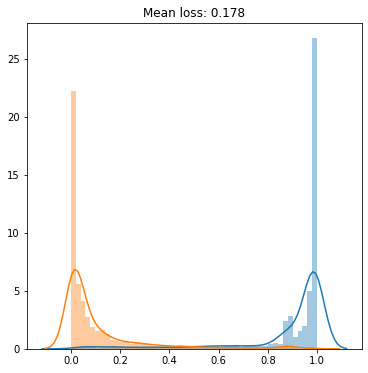

In [31]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

## Weight analysis - eli5

In [32]:
for model in xgb_models:
    display(eli5.explain_weights_xgboost(model, feature_names=featNames))

Weight,Feature
0.3766,large_face_clf_mean_0_bright_spaced
0.2033,large_face_clf_mean_1_bright_spaced
0.1002,large_face_clf_median_1_bright_spaced
0.0456,seq_clf_len-5_start-10_0_zoom_mean
0.0243,large_face_clf_max_1_original_spaced
0.0227,large_face_clf_median_0_bright_spaced
0.0161,large_face_clf_max_0_bright_spaced
0.0119,seq_clf_len-5_start-10_1_original_mean
0.0109,large_face_clf_max_1_bright_first
0.0101,large_face_clf_max_1_bright_spaced


Weight,Feature
0.3533,large_face_clf_mean_1_bright_spaced
0.2141,large_face_clf_median_1_bright_spaced
0.1041,large_face_clf_mean_0_bright_spaced
0.0522,large_face_clf_max_1_bright_spaced
0.0395,large_face_clf_max_0_bright_spaced
0.0239,large_face_clf_max_1_bright_first
0.0212,large_face_clf_median_0_bright_spaced
0.0143,small_face_clf_max_0_original_spaced
0.0140,small_face_clf_mean_0_bright_spaced
0.0136,large_face_clf_median_1_bright_first


Weight,Feature
0.4042,large_face_clf_mean_0_bright_spaced
0.1821,large_face_clf_mean_1_bright_spaced
0.0634,large_face_clf_median_1_bright_spaced
0.0390,seq_clf_len-5_start-10_0_zoom_mean
0.0373,large_face_clf_max_1_bright_spaced
0.0363,large_face_clf_mean_1_bright_first
0.0265,small_face_clf_median_1_zoom_spaced
0.0146,large_face_clf_max_0_bright_spaced
0.0130,large_face_clf_max_1_zoom_spaced
0.0125,large_face_clf_max_1_original_spaced


Weight,Feature
0.3176,large_face_clf_mean_1_bright_spaced
0.1237,large_face_clf_mean_0_bright_spaced
0.1120,large_face_clf_median_1_bright_spaced
0.1002,large_face_clf_mean_0_original_spaced
0.0383,large_face_clf_median_0_bright_spaced
0.0363,seq_clf_len-5_start-10_1_bright_mean
0.0296,large_face_clf_max_1_bright_spaced
0.0181,small_face_clf_median_1_zoom_spaced
0.0153,small_face_clf_max_1_zoom_spaced
0.0138,small_face_clf_mean_1_zoom_spaced


Weight,Feature
0.3620,large_face_clf_mean_1_bright_spaced
0.1633,large_face_clf_median_0_bright_spaced
0.1280,large_face_clf_median_1_bright_spaced
0.0626,seq_clf_len-5_start-10_0_zoom_mean
0.0542,small_face_clf_mean_0_zoom_spaced
0.0496,large_face_clf_mean_0_bright_spaced
0.0191,large_face_clf_max_1_bright_spaced
0.0179,small_face_clf_median_1_zoom_spaced
0.0106,large_face_clf_max_0_bright_spaced
0.0090,large_face_clf_mean_1_bright_first


In [33]:
pd.DataFrame({'Variable':featNames,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
76,large_face_clf_mean_1_bright_spaced,0.362002
71,large_face_clf_median_0_bright_spaced,0.163271
79,large_face_clf_median_1_bright_spaced,0.127994
116,seq_clf_len-5_start-10_0_zoom_mean,0.062579
36,small_face_clf_mean_0_zoom_spaced,0.054204
...,...,...
52,large_face_clf_mean_0_original_spaced,0.000000
51,large_face_clf_median_0_original_first,0.000000
50,large_face_clf_std_0_original_first,0.000000
48,large_face_clf_mean_0_original_first,0.000000


## Logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.externals import joblib
import pickle

In [35]:
losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
lr_models = []
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

    filename = str(os.path.join(DIR_EXPERIMENT,'second_level_LogReg_{0}.sav'.format(fold)))
    #pickle.dump(clf, open(filename, 'wb'))
    #clf = pickle.load(open(filename,'rb'))
    joblib.dump(clf, filename)
    clf = joblib.load(filename)
    lr_models.append(clf)
    
    y_pred = np.clip(clf.predict_proba(X_test)[:,1],eps, 1-eps)
    y_pred_train = np.clip(clf.predict_proba(X_train)[:,1],eps, 1-eps)
    #y_pred = np.clip(y_pred,0.4,1.0)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

/home/joni/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/joni/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 train_loss: 0.130, val_loss: 0.187
Fold 1 train_loss: 0.126, val_loss: 0.199


/home/joni/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/joni/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 train_loss: 0.139, val_loss: 0.141
Fold 3 train_loss: 0.130, val_loss: 0.180
Fold 4 train_loss: 0.147, val_loss: 0.103

Mean train_loss 0.134, val_loss 0.162
train loss std 0.008, val loss std 0.035


/home/joni/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 1.0, 'Mean loss: 0.162')

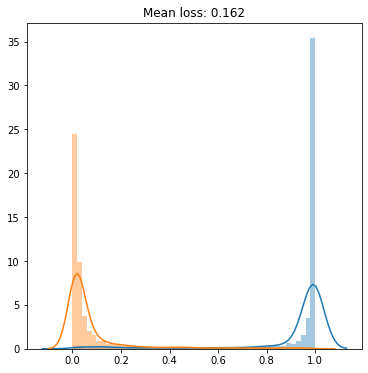

In [36]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

In [37]:
for clf in lr_models:
    display(eli5.explain_weights_sklearn(clf,feature_names=featNames))

Weight?,Feature
+2.799,small_face_embedding_max_consecutive_diff
+2.089,large_face_clf_mean_0_bright_spaced
+1.582,large_face_clf_median_1_bright_spaced
+1.453,large_face_clf_median_0_bright_spaced
+1.336,large_face_clf_mean_1_bright_spaced
+1.175,large_face_clf_std_0_zoom_first
+1.027,small_face_embedding_max_spaced_consecutive_diff
+0.944,small_face_clf_mean_1_zoom_spaced
+0.933,large_face_clf_mean_0_bright_first
+0.923,small_face_clf_mean_0_zoom_spaced


Weight?,Feature
+2.806,small_face_embedding_max_consecutive_diff
+2.450,large_face_clf_mean_0_bright_spaced
+1.611,large_face_clf_median_1_bright_spaced
+1.606,small_face_embedding_max_spaced_consecutive_diff
+1.538,large_face_clf_mean_0_bright_first
+1.366,small_face_clf_mean_0_bright_spaced
+1.267,small_face_clf_mean_1_zoom_spaced
+1.160,large_face_clf_std_0_zoom_first
+1.112,small_face_clf_mean_0_zoom_spaced
+0.994,small_face_clf_max_0_zoom_first


Weight?,Feature
+2.946,small_face_embedding_max_consecutive_diff
+2.211,large_face_clf_mean_0_bright_spaced
+1.581,large_face_clf_std_0_zoom_first
+1.578,large_face_clf_mean_0_bright_first
+1.520,large_face_clf_mean_1_bright_spaced
+1.366,small_face_clf_mean_0_zoom_spaced
+1.261,small_face_clf_mean_1_zoom_spaced
+1.237,small_face_clf_max_0_zoom_first
+1.163,small_face_embedding_max_spaced_consecutive_diff
+1.131,small_face_embedding_max_centroid_diff


Weight?,Feature
+2.981,small_face_embedding_max_consecutive_diff
+2.885,large_face_clf_mean_0_bright_spaced
+1.714,large_face_clf_mean_1_bright_spaced
+1.534,small_face_clf_mean_1_zoom_spaced
+1.427,large_face_clf_median_1_bright_spaced
+1.297,small_face_clf_mean_0_bright_spaced
+1.111,small_face_embedding_max_spaced_consecutive_diff
+1.062,large_face_clf_std_0_zoom_first
+1.012,small_face_embedding_max_centroid_diff
+1.012,small_face_clf_mean_0_zoom_spaced


Weight?,Feature
+2.842,small_face_embedding_max_consecutive_diff
+2.715,large_face_clf_mean_0_bright_spaced
+1.669,small_face_embedding_max_spaced_consecutive_diff
+1.536,large_face_clf_mean_1_bright_spaced
+1.480,small_face_clf_mean_1_zoom_spaced
+1.233,large_face_clf_mean_0_bright_first
+1.175,small_face_clf_mean_0_bright_spaced
+1.128,small_face_clf_mean_0_zoom_spaced
+1.064,large_face_clf_median_0_bright_spaced
+0.961,small_face_clf_max_0_zoom_first
